In [1]:
import mne
import pandas as pd
import numpy as np

In [4]:
np.random.seed(42)

In [3]:
subjects = []

for i in range(1, 8):
    sub = pd.read_pickle(f"./preprocessed_data/processed_psd_sub-0{i}.pkl")
    subjects.append(sub)

df = pd.concat(subjects)
del subjects

frequency_bins = df["freq"].unique()

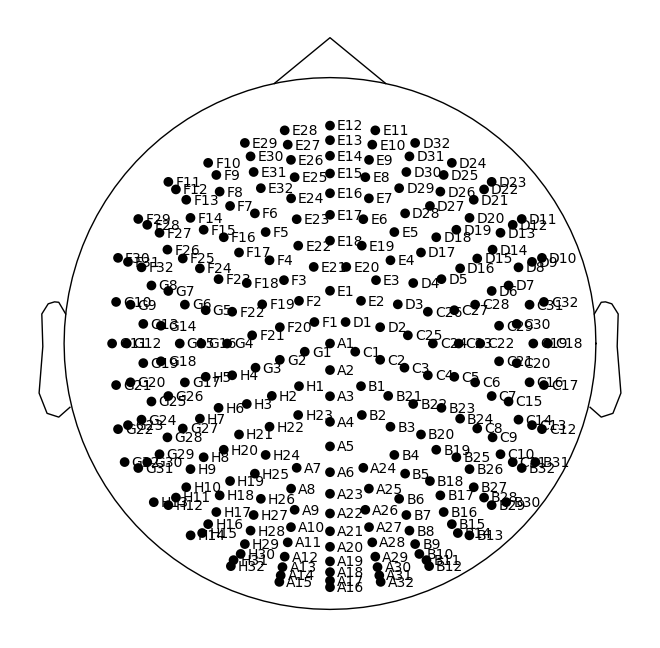

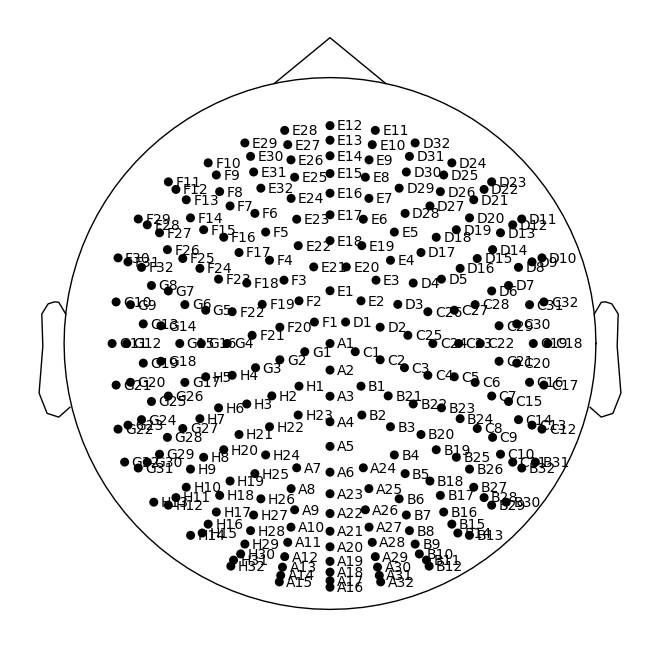

In [26]:
biosemi_montage = mne.channels.make_standard_montage('biosemi256')

biosemi_montage.get_positions()

biosemi_montage.plot()

In [5]:

frontal_channels = [
    "F10",
    "E29", 
    "E28", 
    "E11", 
    "E12", 
    "D32", 
    "D24", 
    "D25", 
    "D31", 
    "E10", 
    "E13", 
    "E27", 
    "E30", 
    "F9"
]

positive_emotions = {
    "awe",
    "compassion",
    "content",
    "excite",
    "happy",
    "joy",
    "love",
    "relief",
}

negative_emotions = {
    "anger",
    "disgust",
    "fear",
    "frustration",
    "grief",
    "jealousy",
    "sad"
}

In [6]:
df["valence"] = df["emotion"].apply(lambda x : "+" if x in positive_emotions else "-")

In [7]:
epochs = df["epoch"].unique()
processed_epochs = []

for epoch in epochs:
    epoch_dict = {}
    channels_series = {}
    df_epoch = df.loc[df["epoch"] == epoch, ("value", "valence", "channel")]

    for channel in frontal_channels:
        series = np.array(df_epoch.loc[
            df_epoch["channel"] == channel, "value"
        ])
        if len(series) > 0:
            channels_series[channel] = series
    
    epoch_dict["channels"] = channels_series
    epoch_dict["valence"] = str(df_epoch.iloc[0]["valence"])
    processed_epochs.append(epoch_dict)


In [8]:
# Delete the original dataframe for performance.

del df

In [9]:
def get_frequency_bands_features(power_spectrum_dict):
    frequency_bands = {
        'alpha': (8, 13),
        'beta': (13, 30),
        'theta': (4, 8),
        'delta': (0.5, 4),
        'gamma': (30, 40)
    }

    transformed_dict = {}

    for channel, power_spectrum in power_spectrum_dict.items():
        for band, (f_min, f_max) in frequency_bands.items():
            band_indices = np.where(
                np.logical_and(frequency_bins >= f_min, frequency_bins <= f_max)
            )
            band_power_values = power_spectrum[band_indices]
            band_mean = np.nanmean(band_power_values)
            band_std_dev = np.nanstd(band_power_values)
            transformed_dict[f"{channel}_{band}_mean"] = band_mean
            transformed_dict[f"{channel}_{band}_stddev"] = band_std_dev

    return transformed_dict

In [10]:
features_dict = []

for idx, epoch in enumerate(processed_epochs):
    features_dict.append({
        "valence": epoch["valence"],
        **get_frequency_bands_features(epoch["channels"])
    })

df_processed = pd.DataFrame(features_dict)
df_processed

,valence,F17_alpha_mean,F17_alpha_stddev,F17_beta_mean,F17_beta_stddev,F17_theta_mean,F17_theta_stddev,F17_delta_mean,F17_delta_stddev,F17_gamma_mean,...,G28_alpha_mean,G28_alpha_stddev,G28_beta_mean,G28_beta_stddev,G28_theta_mean,G28_theta_stddev,G28_delta_mean,G28_delta_stddev,G28_gamma_mean,G28_gamma_stddev
0,+,8.352836e-10,5.484993e-10,4.337171e-10,4.408125e-10,1.232654e-09,3.769546e-10,1.689874e-09,3.673128e-10,4.033669e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+,4.549689e-10,1.369061e-10,3.198344e-10,3.353975e-10,6.000276e-10,9.318567e-11,1.272539e-09,4.073676e-10,2.480152e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,+,8.263550e-10,2.198424e-10,2.803286e-10,3.047862e-10,1.015203e-09,3.124094e-10,1.151060e-09,3.362047e-10,2.738567e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,+,5.604340e-10,3.620963e-10,3.096410e-10,2.319816e-10,1.198434e-09,2.206468e-10,1.216137e-09,4.001162e-10,2.897165e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,+,1.635995e-09,1.439893e-09,3.665596e-10,2.736692e-10,4.069566e-09,1.582618e-09,5.052899e-10,7.512648e-11,3.826375e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,-,3.155217e-10,2.885241e-11,1.343679e-10,1.017017e-10,3.491341e-10,1.091885e-10,1.063484e-09,4.100939e-10,2.897003e-11,...,2.646883e-10,1.060761e-10,8.382827e-11,7.879722e-11,5.101221e-10,1.415301e-10,6.088398e-10,1.073597e-10,4.038296e-11,1.935782e-11
524,-,3.382616e-10,1.630606e-10,1.296434e-10,1.191174e-10,3.970235e-10,9.070647e-11,4.564211e-10,1.070584e-10,2.537387e-11,...,2.339503e-10,1.139760e-10,7.271700e-11,5.316385e-11,4.585467e-10,1.175004e-10,4.270384e-10,7.162699e-11,4.235143e-11,1.185824e-11
525,+,1.087309e-09,4.737202e-10,2.188732e-10,2.048992e-10,5.057326e-10,1.920594e-10,1.772694e-09,5.643604e-10,3.186739e-11,...,9.861408e-10,2.769852e-10,8.047479e-11,8.447460e-11,2.730375e-10,6.552438e-11,1.229544e-09,4.726749e-10,3.332344e-11,7.469659e-12
526,-,1.405443e-09,4.589231e-10,2.147093e-09,8.129415e-10,1.473401e-09,4.750179e-10,2.140955e-08,1.583442e-08,4.936447e-09,...,1.611620e-09,5.235173e-10,1.877674e-09,9.215850e-10,1.441782e-09,2.808403e-10,1.765418e-08,1.338079e-08,3.982393e-09,1.325985e-09


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
 
pca.fit(df_processed.dropna(axis=1).iloc[:, 1:])
 
pca_trans = pca.transform(df_processed.dropna(axis=1).iloc[:, 1:])
pca_df = pd.DataFrame(data = pca_trans, columns = ["PC1", "PC2", "PC3"])
pca_df["valence"] = df_processed["valence"]
pca_df

,PC1,PC2,PC3,valence
0,-2.555909e-09,-3.571595e-10,-9.250599e-10,+
1,-2.142285e-09,-3.579048e-10,6.029833e-10,+
2,-2.253878e-09,-1.709058e-09,1.611803e-09,+
3,-4.553193e-09,-3.021752e-09,-1.823296e-10,+
4,-4.113503e-09,1.184908e-09,-3.071594e-09,+
...,...,...,...,...
523,-1.214507e-09,-5.281089e-09,3.981570e-09,-
524,-3.415630e-09,-5.843138e-09,2.343739e-09,-
525,9.555027e-09,-1.545024e-09,8.676541e-09,+
526,6.275503e-07,-9.964513e-08,-8.992988e-08,-


In [12]:
pca.explained_variance_ratio_

array([0.7103751 , 0.12502542, 0.07543023])

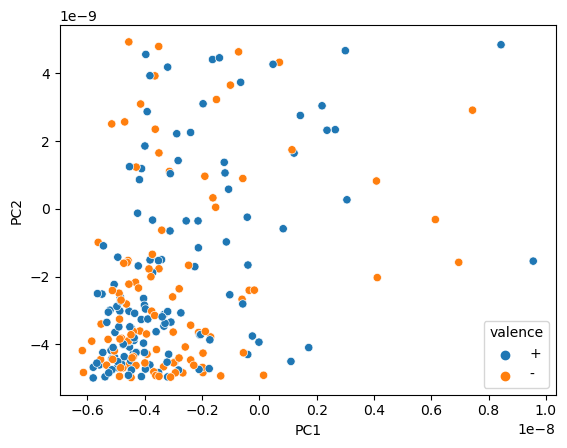

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_df[(pca_df["PC1"] < 1e-8) & (pca_df["PC2"] < 0.5e-8) & (pca_df["PC2"] > -0.5e-8)], x="PC1", y="PC2", hue="valence")
plt.show()
plt.close()


In [66]:
pca.components_[0]

array([ 5.68455690e-02,  4.99016110e-02,  1.73442623e-02,  1.54457787e-02,
        4.28103707e-01,  1.44735487e-01,  4.05294766e-01,  1.10547142e-01,
        4.16797313e-04,  1.80829863e-04,  3.35295658e-02,  2.34553882e-02,
        4.93264181e-03,  5.51711390e-03,  3.80728253e-01,  1.14624188e-01,
        4.10280033e-01,  1.07124199e-01, -1.43213376e-03, -4.83022542e-04,
        3.10963899e-02,  1.56053063e-02,  5.29406722e-03,  7.13973760e-03,
        3.45551873e-01,  9.89856714e-02,  3.66508814e-01,  9.26130634e-02,
       -1.89747480e-03, -6.59013932e-04])

In [6]:
def get_frequency_bands_features(power_spectrum_dict):
    frequency_bands = {
        'alpha': (8, 13),
        'beta': (13, 30),
        'theta': (4, 8),
        'delta': (0.5, 4),
        'gamma': (30, 40)
    }

    transformed_dict = {}

    for band, (f_min, f_max) in frequency_bands.items():
        indices = np.where(np.logical_and(frequency_bins >= f_min, frequency_bins <= f_max))
        channel_means = []
        channel_stddevs = []

        for _, power_spectrum in power_spectrum_dict.items():
            power_values = power_spectrum[indices]
            channel_means.append(np.nanmean(power_values))
            channel_stddevs.append(np.nanstd(power_values))

        transformed_dict[f"{band}_mean"] = np.mean(channel_means)
        transformed_dict[f"{band}_stddev"] = np.mean(channel_stddevs)

    return transformed_dict

In [9]:
features_dict = []

for idx, epoch in enumerate(processed_epochs):
    features_dict.append({
        "valence": epoch["valence"],
        **get_frequency_bands_features(epoch["channels"])
    })

df_processed = pd.DataFrame(features_dict)
df_processed

,valence,alpha_mean,alpha_stddev,beta_mean,beta_stddev,theta_mean,theta_stddev,delta_mean,delta_stddev,gamma_mean,gamma_stddev
0,+,6.708525e-10,5.101992e-10,2.396946e-10,2.260534e-10,1.536764e-09,3.592209e-10,1.219014e-09,2.973887e-10,3.928875e-11,1.656844e-11
1,+,3.854445e-10,2.236984e-10,2.107650e-10,1.577168e-10,8.516365e-10,1.851201e-10,1.392824e-09,3.584204e-10,4.194206e-11,2.263298e-11
2,+,3.239599e-10,6.523589e-11,2.150017e-10,1.625673e-10,6.312605e-10,1.125875e-10,1.376286e-09,3.701379e-10,4.107593e-11,1.557431e-11
3,+,5.023116e-10,2.264501e-10,1.839557e-10,1.390440e-10,8.572610e-10,1.936632e-10,8.947341e-10,2.540820e-10,4.281888e-11,1.208250e-11
4,+,6.481647e-10,3.179918e-10,2.443792e-10,1.980991e-10,1.422986e-09,3.312725e-10,7.354928e-10,2.204857e-10,4.499966e-11,1.800204e-11
...,...,...,...,...,...,...,...,...,...,...,...
460,-,3.650832e-10,8.137911e-11,1.339503e-10,7.741354e-11,3.334848e-10,9.716264e-11,9.831529e-10,3.048939e-10,4.264407e-11,1.214008e-11
461,+,3.517522e-10,6.563102e-11,1.689106e-10,1.077236e-10,3.985780e-10,1.450985e-10,1.262654e-09,2.615833e-10,6.905864e-11,2.166951e-11
462,+,3.756844e-10,1.021109e-10,1.785281e-10,8.053661e-11,3.420361e-10,1.461863e-10,1.325174e-09,4.072604e-10,6.724249e-11,2.140977e-11
463,+,4.165199e-10,1.257139e-10,1.683032e-10,5.396344e-11,2.858851e-10,6.705008e-11,2.230672e-09,9.908930e-10,6.777310e-11,2.372712e-11


[0.8892044  0.07067194 0.03170365]


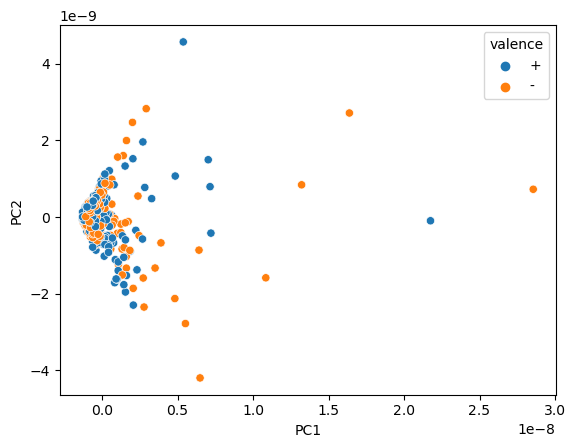

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
 
pca.fit(df_processed.dropna(axis=1).iloc[:, 1:])
 
pca_trans = pca.transform(df_processed.dropna(axis=1).iloc[:, 1:])
pca_df = pd.DataFrame(data = pca_trans, columns = ["PC1", "PC2", "PC3"])
pca_df["valence"] = df_processed["valence"]

print(pca.explained_variance_ratio_)

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="valence")
plt.show()
plt.close()

/tmp/ipykernel_412530/709105623.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_processed.corr(), cmap="YlGnBu", annot=True)


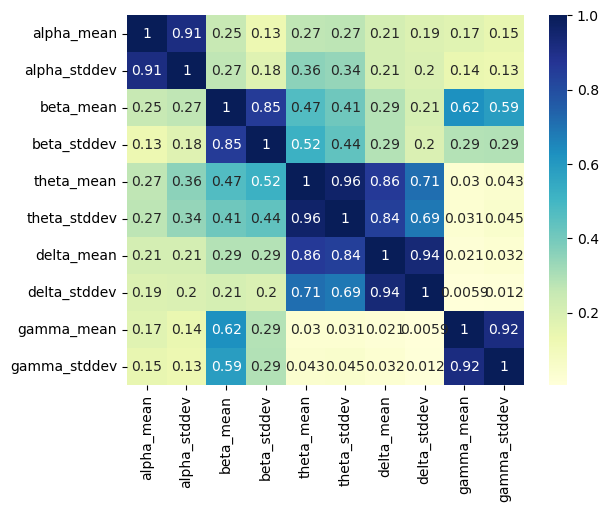

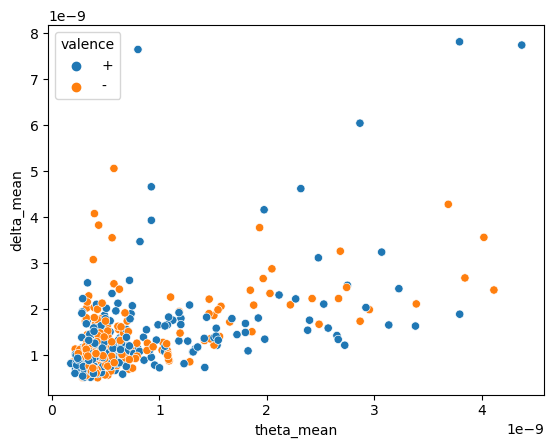

In [14]:
sns.heatmap(df_processed.corr(), cmap="YlGnBu", annot=True)
plt.show()
plt.close()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_processed.drop("valence", axis=1), df_processed["valence"], test_size=0.2, random_state=42)

In [18]:
X_train

,alpha_mean,alpha_stddev,beta_mean,beta_stddev,theta_mean,theta_stddev,delta_mean,delta_stddev,gamma_mean,gamma_stddev
360,9.823096e-10,4.271393e-10,1.293792e-10,7.002471e-11,4.965418e-10,1.931384e-10,1.794654e-09,6.197350e-10,5.303477e-11,2.514415e-11
241,9.094801e-10,3.538028e-10,2.883736e-10,1.388700e-10,7.773545e-10,2.476054e-10,9.309101e-10,3.700416e-10,1.362968e-10,3.677118e-11
36,9.683999e-10,2.887508e-10,3.107240e-10,3.683320e-10,1.846899e-09,3.128716e-10,2.413671e-09,7.363431e-10,6.241048e-11,1.894393e-11
445,3.691921e-10,1.085476e-10,1.194422e-10,7.425861e-11,3.348069e-10,8.168004e-11,1.114154e-09,4.209934e-10,3.092184e-11,1.298771e-11
11,8.855111e-10,4.830192e-10,3.033064e-10,2.726511e-10,2.487185e-09,8.007421e-10,1.674365e-09,4.750927e-10,3.343327e-11,1.038087e-11
...,...,...,...,...,...,...,...,...,...,...
391,6.076572e-10,2.230009e-10,1.016090e-10,5.448578e-11,4.090009e-10,1.095154e-10,9.726704e-10,4.400034e-10,2.227719e-11,7.717697e-12
16,7.004934e-10,2.747012e-10,2.499203e-10,1.748934e-10,1.073286e-09,3.376949e-10,1.105977e-09,3.237866e-10,4.009701e-11,1.279043e-11
313,4.663102e-10,2.366929e-10,6.188686e-11,3.688344e-11,2.395831e-10,6.391467e-11,8.964787e-10,3.266371e-10,2.826653e-11,7.777180e-12
292,4.119417e-10,1.692702e-10,9.276790e-11,3.859331e-11,3.715353e-10,8.429234e-11,6.115647e-10,1.733438e-10,3.565637e-11,1.494497e-11


In [20]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



In [24]:
accuracy_score(y_test, y_pred)

0.5376344086021505

In [22]:
confusion_matrix(y_test, y_pred)

array([[50,  0],
       [43,  0]])